### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.options.display.max_columns= None
pd.options.display.max_rows = None

### Data Exploration

In [2]:
df = pd.read_csv("BX.csv")

In [3]:
df.head()

Borough  Block  Lot   CD  CT2010  CB2010  SchoolDist  Council  ZipCode  \
0      BX   2260    1  201    19.0  1022.0         7.0      8.0  10454.0   
1      BX   2260    4  201    19.0  1022.0         7.0      8.0  10454.0   
2      BX   2260   10  201    19.0  1022.0         7.0      8.0  10454.0   
3      BX   2260   17  201    19.0  1022.0         7.0      8.0  10454.0   
4      BX   2260   18  201    19.0  1022.0         7.0      8.0  10454.0   

  FireComp  PolicePrct  HealthCenterDistrict  HealthArea  SanitBoro  \
0     L029        40.0                  23.0      4700.0        2.0   
1     L029        40.0                  23.0      4700.0        2.0   
2     L029        40.0                  23.0      4700.0        2.0   
3     L029        40.0                  23.0      4700.0        2.0   
4     L029        40.0                  23.0      4700.0        2.0   

   SanitDistrict SanitSub                 Address ZoneDist1 ZoneDist2  \
0            1.0       2A  122 BRUCKNER BOULEVARD  M1-5/R8A       NaN   
1            1.0       2A  126 BRUCKNER BOULEVARD  M1-5/R8A       NaN   
2            1.0       2A  138 BRUCKNER BOULEVARD  M1-5/R8A       NaN   
3            1.0       2A  144 BRUCKNER BOULEVARD  M1-5/R8A       NaN   
4            1.0       2A  148 BRUCKNER BOULEVARD  M1-5/R8A       NaN   

  ZoneDist3 ZoneDist4 Overlay1 Overlay2 SPDist1  SPDist2  SPDist3  LtdHeight  \
0       NaN       NaN      NaN      NaN    MX-1      NaN      NaN        NaN   
1       NaN       NaN      NaN      NaN    MX-1      NaN      NaN        NaN   
2       NaN       NaN      NaN      NaN    MX-1      NaN      NaN        NaN   
3       NaN       NaN      NaN      NaN    MX-1      NaN      NaN        NaN   
4       NaN       NaN      NaN      NaN    MX-1      NaN      NaN        NaN   

  SplitZone BldgClass  LandUse  Easements OwnerType              OwnerName  \
0         N        Z9      NaN          0       NaN  122 BRUCKNER PARTNERS   
1         N        G5      7.0          0       NaN  24 INDIAN HEAD HOLDIN   
2         N        F5      6.0          0         P            ANJOST CORP   
3         N        C1      2.0          0       NaN       144 BRUCKNER LLC   
4         N        C7      2.0          0         P       148 BRUCKNER LLC   

   LotArea  BldgArea  ComArea  ResArea  OfficeArea  RetailArea  GarageArea  \
0    15000         0        0        0           0           0           0   
1    13770       752      752        0         272           0           0   
2    35000     39375    39375        0           0           0           0   
3     2500     12500        0    12500           0           0           0   
4     1875      8595     1719     6876           0        1719           0   

   StrgeArea  FactryArea  OtherArea  AreaSource  NumBldgs  NumFloors  \
0          0           0          0           7         1        0.0   
1        480           0          0           2         2        1.0   
2          0       39375          0           2         1        2.0   
3          0           0          0           2         1        5.0   
4          0           0          0           2         1        5.0   

   UnitsRes  UnitsTotal  LotFront  LotDepth  BldgFront  BldgDepth  Ext  \
0         0           0     75.00     200.0        0.0        0.0  NaN   
1         0           1    137.58     100.0       16.0       16.0  NaN   
2         0           1    175.00     200.0      175.0      200.0  NaN   
3        15          15     25.00     100.0       25.0       85.0  NaN   
4         8          10     25.00      75.0       25.0       70.0  NaN   

   ProxCode IrrLotCode  LotType  BsmtCode  AssessLand  AssessTot  ExemptLand  \
0       0.0          N      3.0       0.0      130500     161100           0   
1       0.0          N      5.0       0.0      117000     326700           0   
2       0.0          N      4.0       0.0      153000     879300           0   
3       0.0          N      5.0       0.0       51300     3325

In [4]:
df = df[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 
         'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 
         'ZipCode', 'YCoord', 'XCoord']]

In [5]:
df.head()

Address  BldgArea  BldgDepth  BuiltFAR  CommFAR  FacilFAR  \
0  122 BRUCKNER BOULEVARD         0        0.0      0.00      5.0       6.5   
1  126 BRUCKNER BOULEVARD       752       16.0      0.05      5.0       6.5   
2  138 BRUCKNER BOULEVARD     39375      200.0      1.13      5.0       6.5   
3  144 BRUCKNER BOULEVARD     12500       85.0      5.00      5.0       6.5   
4  148 BRUCKNER BOULEVARD      8595       70.0      4.58      5.0       6.5   

   Lot  LotArea  LotDepth  NumBldgs  NumFloors  OfficeArea  ResArea  ResidFAR  \
0    1    15000     200.0         1        0.0           0        0      6.02   
1    4    13770     100.0         2        1.0         272        0      6.02   
2   10    35000     200.0         1        2.0           0        0      6.02   
3   17     2500     100.0         1        5.0           0    12500      6.02   
4   18     1875      75.0         1        5.0           0     6876      6.02   

   RetailArea  YearBuilt  YearAlter1  ZipCode    YCoord     XCoord  
0           0          0           0  10454.0  232162.0  1005957.0  
1           0       1931        1994  10454.0  232156.0  1006076.0  
2           0       1931           0  10454.0  232036.0  1006187.0  
3           0       1931        2001  10454.0  232033.0  1006299.0  
4        1719       1920        2009  10454.0  232040.0  1006363.0

In [6]:
#df.to_csv("partthree.csv",index=False)

In [7]:
df = pd.read_csv("partthree.csv")

In [8]:
df.head()

Address  BldgArea  BldgDepth  BuiltFAR  CommFAR  FacilFAR  \
0  122 BRUCKNER BOULEVARD         0        0.0      0.00      5.0       6.5   
1  126 BRUCKNER BOULEVARD       752       16.0      0.05      5.0       6.5   
2  138 BRUCKNER BOULEVARD     39375      200.0      1.13      5.0       6.5   
3  144 BRUCKNER BOULEVARD     12500       85.0      5.00      5.0       6.5   
4  148 BRUCKNER BOULEVARD      8595       70.0      4.58      5.0       6.5   

   Lot  LotArea  LotDepth  NumBldgs  NumFloors  OfficeArea  ResArea  ResidFAR  \
0    1    15000     200.0         1        0.0           0        0      6.02   
1    4    13770     100.0         2        1.0         272        0      6.02   
2   10    35000     200.0         1        2.0           0        0      6.02   
3   17     2500     100.0         1        5.0           0    12500      6.02   
4   18     1875      75.0         1        5.0           0     6876      6.02   

   RetailArea  YearBuilt  YearAlter1  ZipCode    YCoord     XCoord  
0           0          0           0  10454.0  232162.0  1005957.0  
1           0       1931        1994  10454.0  232156.0  1006076.0  
2           0       1931           0  10454.0  232036.0  1006187.0  
3           0       1931        2001  10454.0  232033.0  1006299.0  
4        1719       1920        2009  10454.0  232040.0  1006363.0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89854 entries, 0 to 89853
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Address     89785 non-null  object 
 1   BldgArea    89854 non-null  int64  
 2   BldgDepth   89854 non-null  float64
 3   BuiltFAR    89854 non-null  float64
 4   CommFAR     89854 non-null  float64
 5   FacilFAR    89854 non-null  float64
 6   Lot         89854 non-null  int64  
 7   LotArea     89854 non-null  int64  
 8   LotDepth    89854 non-null  float64
 9   NumBldgs    89854 non-null  int64  
 10  NumFloors   89854 non-null  float64
 11  OfficeArea  89854 non-null  int64  
 12  ResArea     89854 non-null  int64  
 13  ResidFAR    89854 non-null  float64
 14  RetailArea  89854 non-null  int64  
 15  YearBuilt   89854 non-null  int64  
 16  YearAlter1  89854 non-null  int64  
 17  ZipCode     89525 non-null  float64
 18  YCoord      86595 non-null  float64
 19  XCoord      86595 non-nul

In [10]:
df.describe(include='all')

Address      BldgArea     BldgDepth      BuiltFAR       CommFAR  \
count         89785  8.985400e+04  89854.000000  89854.000000  89854.000000   
unique        87017           NaN           NaN           NaN           NaN   
top     SHORE DRIVE           NaN           NaN           NaN           NaN   
freq             42           NaN           NaN           NaN           NaN   
mean            NaN  8.113609e+03     48.229342      1.107134      0.130644   
std             NaN  6.520439e+04     31.333564      1.799155      0.574606   
min             NaN  0.000000e+00      0.000000      0.000000      0.000000   
25%             NaN  1.598000e+03     35.000000      0.550000      0.000000   
50%             NaN  2.226000e+03     44.670000      0.860000      0.000000   
75%             NaN  3.288000e+03     55.000000      1.250000      0.000000   
max             NaN  1.354011e+07   1300.000000    259.800000      9.000000   

            FacilFAR           Lot       LotArea      LotDepth      NumBldgs  \
count   89854.000000  89854.000000  8.985400e+04  89854.000000  89854.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        2.853723    111.493601  1.023904e+04    105.978085      1.184778   
std         1.605805    467.387099  3.058252e+05     73.946506      1.929445   
min         0.000000      1.000000  0.000000e+00      0.000000      0.000000   
25%         2.000000     20.000000  2.188000e+03     95.000000      1.000000   
50%         2.000000     41.000000  2.508000e+03    100.000000      1.000000   
75%         4.800000     73.000000  4.250000e+03    102.420000      1.000000   
max        10.000000   9978.000000  7.425000e+07   8000.000000    251.000000   

           NumFloors    OfficeArea       ResArea      ResidFAR     RetailArea  \
count   89854.000000  8.985400e+04  8.985400e+04  89854.000000   89854.000000   
unique           NaN           NaN           NaN           NaN            NaN   
top              NaN           NaN           NaN           NaN            NaN   
freq             NaN           NaN           NaN           NaN            NaN   
mean        2.273265  5.057144e+02  5.720876e+03      1.674844     349.916910   
std         1.492908  1.196641e+04  5.660190e+04      1.309456    4911.023897   
min         0.000000  0.000000e+00  0.000000e+00      0.000000       0.000000   
25%         2.000000  0.000000e+00  1.152000e+03      0.900000       0.000000   
50%         2.000000  0.000000e+00  1.760000e+03      1.100000       0.000000   
75%         3.000000  0.000000e+00  2.616000e+03      2.430000       0.000000   
max        44.000000  1.311800e+06  1.321140e+07     10.000000  598908.000000   

           YearBuilt    YearAlter1       ZipCode         YCoord        XCoord  
count   89854.000000  89854.000000  89525.000000   86595.000000  8.659500e+04  
unique           NaN           NaN           NaN            NaN           NaN  
top              NaN           NaN           NaN            NaN           NaN  
freq             NaN           NaN           NaN            NaN           NaN  
mean     1805.695150    176.591782  10464.280726  249975.676667  1.021686e+06  
std       499.485278    567.142346      7.292127    9778.614120  8.599340e+03  
min         0.000000      0.000000  10451.000000  227527.000000  1.002677e+06  
25%      1920.000000      0.000000  10460.000000  241918.000000  1.014310e+06  
50%      1931.000000      0.000000  10465.000000  248586.000000  1.023321e+06  
75%      1960.000000      0.000000  10469.000000  258036.500000  1.027126e+06  
max      2017.000000   2017.000000  11370.000000  272275.000000  1.047777e+06

In [11]:
df.shape

(89854, 20)

In [12]:
df.columns

Index(['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR',
       'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea',
       'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1',
       'ZipCode', 'YCoord', 'XCoord'],
      dtype='object')

### Replace zero value with NaNs

In [13]:
df['Address'].value_counts()

SHORE DRIVE                   42
PALISADE AVENUE               37
WHITE PLAINS ROAD             35
PARK AVENUE                   35
BRUCKNER BOULEVARD            34
MAJ WM DEEGAN BLVD            32
WEST 246 STREET               29
SEDGWICK AVENUE               27
POST ROAD                     22
UNIVERSITY AVENUE             21
3 AVENUE                      21
WESTCHESTER AVENUE            20
BRONX RIVER AVENUE            20
WEBSTER AVENUE                20
BOSTON ROAD                   19
FIELDSTON ROAD                19
JEROME AVENUE                 19
RANDALL AVENUE                19
PAULDING AVENUE               18
BAYCHESTER AVENUE             18
CITY ISLAND AVENUE            18
CROSS BRONX EXPWY             18
INDEPENDENCE AVENUE           17
EAST TREMONT AVENUE           16
KING AVENUE                   16
CORNELL AVENUE                16
VAN NEST AVENUE               16
MORRIS AVENUE                 15
HEATH AVENUE                  15
LURTING AVENUE                15
EAST 213 S

In [14]:
df['BldgArea'].value_counts()

0           6423
2400         679
1152         555
1600         543
3000         512
2280         502
1800         476
2000         455
2800         443
2340         426
2160         413
2100         405
1944         403
1782         367
1890         362
2200         361
1920         356
1680         334
1440         322
1260         317
1400         315
1728         314
2500         310
1280         304
1836         298
2700         290
1224         286
3300         282
1296         279
2040         278
1620         268
1760         266
2125         254
1584         246
3600         242
1320         238
2640         238
1188         237
1690         234
2520         231
1980         226
2600         211
3200         202
2680         201
1900         198
1998         197
2080         190
1683         186
960          185
1902         184
1360         184
5000         182
1512         181
3120         181
1960         179
2310         179
1840         175
3280         172
2750         1

In [15]:
df['BldgArea'].replace(0,np.nan,inplace=True)

In [16]:
df['BldgDepth'].value_counts()

0.00       6687
50.00      4967
36.00      4182
40.00      4099
35.00      3080
32.00      2769
52.00      2521
45.00      2350
30.00      2338
55.00      2196
34.00      2167
37.00      2150
48.00      2057
38.00      1946
60.00      1866
46.00      1782
33.00      1657
42.00      1561
100.00     1363
44.00      1251
47.00      1144
39.00      1041
54.00      1036
43.00      1009
56.00       945
51.00       930
80.00       859
28.00       852
90.00       814
65.00       784
53.00       770
41.00       731
49.00       715
26.00       646
31.00       634
88.00       625
25.00       614
67.00       612
58.00       590
70.00       585
62.00       543
20.00       541
57.00       537
24.00       532
75.00       522
68.00       521
64.00       461
87.00       393
66.00       391
72.00       359
85.00       353
59.00       351
63.00       350
81.00       347
61.00       347
29.00       320
27.00       310
78.00       284
95.00       250
22.00       246
82.00       201
83.00       200
84.00   

In [17]:
df['BldgDepth'].replace(0.00,np.nan,inplace=True)

In [18]:
df['BuiltFAR'].value_counts()

0.00      6521
1.00      1602
0.70       935
0.80       901
0.99       901
0.82       847
0.75       846
0.90       832
0.60       829
0.67       827
0.64       827
0.73       806
0.78       779
0.68       778
0.98       766
0.66       759
0.72       758
0.58       749
0.96       747
0.74       745
0.69       737
0.56       725
0.61       712
0.83       712
0.62       710
0.63       703
1.01       699
0.88       697
0.94       696
0.86       696
0.84       684
0.71       683
0.65       682
0.76       681
0.85       681
0.77       673
0.59       659
0.92       656
0.79       652
0.50       650
0.95       647
0.81       645
1.02       624
0.91       618
0.57       616
0.87       613
1.20       610
0.93       597
0.48       592
0.97       590
0.52       587
0.54       583
0.89       581
0.51       576
0.49       573
1.04       570
0.53       568
0.55       566
1.06       563
1.07       555
1.03       548
1.11       533
1.05       528
1.08       528
1.10       509
1.14       504
0.47      

In [19]:
df['BuiltFAR'].replace(0.00,np.nan,inplace=True)

In [20]:
df['CommFAR'].value_counts()

0.0    83828
1.0     2222
2.0     2139
3.4      887
0.5      335
4.0      205
5.0      106
4.2       58
6.0       46
9.0       17
3.0       11
Name: CommFAR, dtype: int64

In [21]:
df['CommFAR'].replace(0.0,np.nan,inplace=True)

In [22]:
df['FacilFAR'].value_counts()

2.00     43644
4.80     23823
1.00     12035
6.50      3947
2.40      2008
3.00      1849
0.00      1104
4.00       767
6.00       204
5.00       204
4.20       197
7.52        48
9.00        17
10.00        7
Name: FacilFAR, dtype: int64

In [23]:
df['FacilFAR'].replace(0.00,np.nan,inplace=True)

In [24]:
df['Lot'].value_counts()

1       2486
20      1207
15      1178
5       1169
25      1168
10      1163
17      1160
12      1157
16      1149
14      1149
7       1148
18      1143
23      1139
22      1131
26      1130
21      1125
13      1122
19      1110
28      1097
30      1097
24      1095
29      1077
11      1071
40      1053
6       1051
8       1048
27      1036
35      1020
34      1017
37      1015
31      1007
32       998
50       989
38       985
3        962
36       961
42       961
9        959
45       958
33       956
41       925
44       909
39       906
43       906
46       903
48       899
4        886
51       864
47       860
49       857
52       825
53       814
55       797
54       771
56       757
60       743
57       738
58       738
2        718
59       682
61       654
62       618
63       600
64       569
65       566
66       491
70       487
67       487
68       481
69       447
71       406
72       403
73       402
75       386
74       345
80       321
78       311

In [25]:
df['LotArea'].value_counts()

2500        12051
5000         3142
2375         2428
2000         2402
1800         1616
3000          692
1900          654
10000         626
2250          620
4750          574
2575          571
3742          547
2200          530
1710          509
2100          484
4000          450
7500          441
2800          417
2600          378
2300          362
3500          334
3750          327
0             301
2400          301
2700          296
2856          282
3325          280
2900          278
3125          240
4500          230
2850          229
1700          228
1875          216
1600          213
2750          213
2450          213
2860          209
3300          203
2625          201
2442          201
1650          184
15000         179
2125          176
1500          170
12500         170
2435          169
1950          168
2185          166
3600          163
1667          162
3200          161
3555          155
2090          139
3100          134
2060          134
1750      

In [26]:
df['LotArea'].replace(0,np.nan,inplace=True)

In [27]:
df['LotDepth'].value_counts()

100.00     34309
95.00       6337
90.00       1793
103.00      1548
75.00        941
125.00       745
50.00        634
110.00       632
105.00       626
80.00        588
114.25       581
85.00        547
109.42       503
97.42        477
114.42       444
120.00       371
200.00       310
115.00       307
87.42        285
70.00        279
0.00         259
98.00        246
150.00       244
94.75        217
112.00       213
99.00        213
108.25       213
100.08       205
114.67       202
96.00        192
94.00        192
112.42       184
114.17       173
101.00       172
108.33       158
92.00        155
100.25       151
108.00       146
87.50        143
109.00       143
130.00       142
100.50       134
114.00       133
106.00       132
100.42       132
91.00        131
100.01       131
102.00       125
97.00        125
89.00        124
93.00        123
111.42       123
100.17       123
45.00        118
65.00        115
92.42        115
100.33       112
107.42       107
83.00        1

In [28]:
df['LotDepth'].replace(0.00,np.nan,inplace=True)

In [29]:
df['NumBldgs'].value_counts()

1      67052
2      15324
0       6071
3        897
4        203
5         77
6         44
7         27
8         16
9         15
10        15
11        10
12         9
14         8
13         5
15         5
39         4
16         4
17         4
26         3
18         3
21         3
22         3
20         3
31         3
54         3
35         3
46         2
48         2
23         2
58         2
24         2
19         2
57         2
30         2
37         2
47         1
70         1
91         1
52         1
72         1
129        1
64         1
55         1
40         1
44         1
41         1
74         1
230        1
100        1
78         1
33         1
208        1
82         1
251        1
29         1
28         1
62         1
Name: NumBldgs, dtype: int64

In [30]:
df['NumBldgs'].replace(0,np.nan,inplace=True)

In [31]:
df['NumFloors'].value_counts()

2.00     42187
3.00     15207
1.00      9033
0.00      6549
2.50      5077
5.00      3239
6.00      2172
4.00      1711
1.50      1531
2.75      1165
1.75       716
1.67       341
7.00       233
8.00       160
9.00        77
3.50        61
12.00       51
10.00       43
14.00       42
11.00       39
13.00       38
20.00       25
16.00       24
2.67        20
3.75        18
19.00       13
21.00       12
18.00       11
15.00       11
2.25         9
22.00        7
25.00        6
30.00        5
17.00        5
33.00        2
23.00        2
28.00        2
0.50         1
1.25         1
24.00        1
31.00        1
44.00        1
1.33         1
5.50         1
29.00        1
4.50         1
42.00        1
Name: NumFloors, dtype: int64

In [32]:
df['NumFloors'].replace(0.00,np.nan,inplace=True)

In [33]:
df['OfficeArea'].value_counts()

0          87319
1000          78
2000          48
500           38
3000          38
800           28
2500          27
1200          26
5000          26
1500          24
400           19
700           18
1250          18
600           16
4000          15
1600          15
750           14
900           14
300           13
2400          13
1800          13
200           12
1400          11
4500          11
3500          10
8000           9
1300           9
1100           9
10000          9
950            8
2700           8
625            8
1700           8
7500           8
3200           8
1144           7
1750           7
1225           7
1080           7
6000           7
2300           7
9000           6
7000           6
2250           6
2600           6
12000          6
840            5
4250           5
650            5
3250           5
880            5
15000          5
6250           5
1050           5
1008           5
2800           5
612            5
6500           5
7200          

In [34]:
df['OfficeArea'].replace(0,np.nan,inplace=True)

In [35]:
df['ResArea'].value_counts()

0           14487
1152         1161
1296         1045
1600          823
1260          815
1224          771
1440          705
2000          652
1188          611
2400          585
1480          557
1400          551
1280          503
2280          483
1800          438
2800          419
1360          416
2200          413
2100          410
2340          399
1080          395
3000          392
1920          377
1332          371
1680          369
1368          361
960           337
1760          325
1320          322
2160          318
2680          309
2080          290
1116          265
2288          248
1520          248
1200          244
2520          230
2040          228
2640          228
1024          225
2500          216
1690          215
2600          210
1840          209
2700          208
1560          198
1960          198
1088          195
1880          194
1890          187
1900          186
2240          186
2480          185
1344          183
1980          183
1728      

In [36]:
df['ResArea'].replace(0,np.nan,inplace=True)

In [37]:
df['ResidFAR'].value_counts()

0.90     26374
1.25     12901
3.44     12083
2.43     11990
0.60     10462
0.00      4358
1.10      2824
6.02      2416
3.00      1849
0.50      1573
2.00      1054
4.00       767
1.35       491
6.00       204
4.20       197
5.00       172
7.52        49
3.75        32
5.40        21
9.00        17
7.20        14
10.00        6
Name: ResidFAR, dtype: int64

In [38]:
df['ResidFAR'].replace(0.00,np.nan,inplace=True)

In [39]:
df['RetailArea'].value_counts()

0         83962
1000        138
3000        122
2000        116
5000        113
2500        109
800         101
1200         92
1250         86
4000         76
1500         71
625          60
10000        59
600          53
700          52
500          47
6000         45
1800         44
1600         39
1875         38
900          35
3500         35
2400         35
4500         32
1050         31
1400         31
3600         29
750          28
1100         27
7500         27
1300         26
2250         26
3750         24
3200         21
2200         21
2100         21
3400         20
950          20
1900         20
9000         19
3300         19
7000         19
1700         18
400          18
2800         18
2700         17
1750         17
5500         16
8000         16
4200         16
1080         15
2300         15
15000        14
12000        14
4250         13
3125         13
1350         13
3800         13
3250         12
1375         12
2600         12
960          12
1125    

In [40]:
df['RetailArea'].replace(0,np.nan,inplace=True)

In [41]:
df['YearBuilt'].value_counts()

1920    7550
0       6367
1925    6343
1930    5856
1950    5307
1960    4577
1910    3870
1940    3655
1901    3617
1955    3545
1931    3224
1935    2606
1965    2386
1945    1794
1915    1738
1970    1489
1899    1443
1927    1085
1928     986
2006     821
1926     776
2005     746
2004     730
1992     642
2002     631
2007     562
2003     542
2000     541
1905     534
1924     534
1929     529
1993     520
2001     501
1991     447
1987     446
1975     444
2008     439
1999     433
1988     398
1990     363
1997     352
1989     330
1995     327
1998     314
1996     294
1923     291
1922     249
1994     248
1959     232
1963     221
1913     218
1932     210
2009     204
1964     202
1985     201
1956     192
2014     189
1962     188
1961     184
1911     181
1957     178
1912     175
1986     174
1958     169
1953     168
1952     151
1941     149
2010     148
1937     148
1916     146
1954     145
1939     143
1948     142
1951     141
1907     134
2013     134
1909     133

In [42]:
df['YearBuilt'].replace(0,np.nan,inplace=True)

In [43]:
df['YearAlter1'].value_counts()

0       81912
2001      417
1999      387
2000      380
2003      364
2004      358
2007      341
2005      326
1994      296
1991      292
2006      290
2008      274
1996      263
1998      247
2009      218
2002      217
1993      202
1997      202
1995      196
2015      180
1990      180
1992      173
2010      156
2014      152
2016      147
2013      122
2011      121
1988      113
1989       99
2012       94
1987       82
1986       75
1982       75
1983       72
1980       70
1985       69
1984       68
2017       52
1981       48
1979       48
1974       33
1977       32
1978       32
1975       27
1967       23
1976       22
1972       20
1973       19
1962       14
1969       13
1968       13
1961       13
1960       12
1970       11
1965       10
1966       10
1955       10
1971        9
1964        9
1958        9
1963        9
1957        8
1959        7
1954        7
1941        7
1922        5
1939        5
1952        4
1951        4
1942        4
1925        4
1915  

In [44]:
df['YearAlter1'].replace(0,np.nan,inplace=True)

In [45]:
df['ZipCode'].value_counts()

10469.0    11349
10466.0     9229
10465.0     8163
10461.0     7499
10473.0     4870
10467.0     4673
10462.0     4671
10472.0     4329
10457.0     3028
10460.0     2892
10456.0     2876
10458.0     2769
10459.0     2605
10471.0     2352
10470.0     2334
10463.0     2247
10453.0     2102
10455.0     1793
10454.0     1746
10468.0     1627
10464.0     1550
10452.0     1548
10451.0     1228
10474.0     1220
10475.0      823
11370.0        2
Name: ZipCode, dtype: int64

In [46]:
df['YCoord'].value_counts()

252648.0    13
241968.0    12
241219.0    11
236845.0    11
241747.0    11
241492.0    11
240769.0    11
247962.0    11
247757.0    11
245678.0    11
241952.0    10
242195.0    10
244646.0    10
240868.0    10
241572.0    10
250926.0    10
241077.0    10
236370.0    10
241151.0    10
240607.0    10
241347.0    10
241349.0    10
247721.0    10
249126.0    10
242445.0    10
242048.0    10
245373.0    10
241530.0    10
246301.0    10
241016.0    10
243182.0    10
249044.0    10
242037.0    10
255238.0    10
247093.0    10
247818.0    10
248025.0    10
246884.0    10
241276.0    10
241279.0    10
247023.0    10
241490.0    10
263647.0     9
248769.0     9
237438.0     9
241093.0     9
246989.0     9
241103.0     9
241427.0     9
248240.0     9
241437.0     9
246724.0     9
241342.0     9
236325.0     9
244360.0     9
247858.0     9
241241.0     9
258839.0     9
244131.0     9
241259.0     9
255237.0     9
247785.0     9
237358.0     9
263245.0     9
247740.0     9
257611.0     9
240902.0  

In [47]:
df['XCoord'].value_counts()

1024749.0    16
1013809.0    15
1026602.0    15
1026134.0    14
1025387.0    14
1025546.0    14
1025330.0    14
1025176.0    14
1025501.0    14
1026149.0    14
1025127.0    14
1026869.0    14
1025406.0    13
1012994.0    13
1025786.0    13
1026639.0    13
1026195.0    13
1024033.0    13
1024177.0    13
1024297.0    13
1025938.0    13
1024383.0    13
1013799.0    13
1026376.0    13
1026105.0    13
1025738.0    13
1025565.0    13
1025383.0    13
1024585.0    13
1025798.0    13
1024963.0    12
1025810.0    12
1025124.0    12
1025809.0    12
1025433.0    12
1024030.0    12
1024976.0    12
1026398.0    12
1023946.0    12
1026184.0    12
1022063.0    12
1025924.0    12
1014366.0    12
1024845.0    12
1024849.0    12
1024853.0    12
1024805.0    12
1025839.0    12
1025377.0    12
1025162.0    12
1025385.0    12
1024915.0    12
1026448.0    12
1026203.0    12
1025668.0    12
1026202.0    12
1025818.0    12
1026287.0    12
1024072.0    12
1025694.0    12
1026595.0    12
1025522.0    12
1025033.

In [48]:
#Save to csv
#df.to_csv("partthreenan.csv",index=False)

### Treat Missing Values

In [49]:
df = pd.read_csv("partthreenan.csv")

In [50]:
df.head()

Address  BldgArea  BldgDepth  BuiltFAR  CommFAR  FacilFAR  \
0  122 BRUCKNER BOULEVARD       NaN        NaN       NaN      5.0       6.5   
1  126 BRUCKNER BOULEVARD     752.0       16.0      0.05      5.0       6.5   
2  138 BRUCKNER BOULEVARD   39375.0      200.0      1.13      5.0       6.5   
3  144 BRUCKNER BOULEVARD   12500.0       85.0      5.00      5.0       6.5   
4  148 BRUCKNER BOULEVARD    8595.0       70.0      4.58      5.0       6.5   

   Lot  LotArea  LotDepth  NumBldgs  NumFloors  OfficeArea  ResArea  ResidFAR  \
0    1  15000.0     200.0       1.0        NaN         NaN      NaN      6.02   
1    4  13770.0     100.0       2.0        1.0       272.0      NaN      6.02   
2   10  35000.0     200.0       1.0        2.0         NaN      NaN      6.02   
3   17   2500.0     100.0       1.0        5.0         NaN  12500.0      6.02   
4   18   1875.0      75.0       1.0        5.0         NaN   6876.0      6.02   

   RetailArea  YearBuilt  YearAlter1  ZipCode    YCoord     XCoord  
0         NaN        NaN         NaN  10454.0  232162.0  1005957.0  
1         NaN     1931.0      1994.0  10454.0  232156.0  1006076.0  
2         NaN     1931.0         NaN  10454.0  232036.0  1006187.0  
3         NaN     1931.0      2001.0  10454.0  232033.0  1006299.0  
4      1719.0     1920.0      2009.0  10454.0  232040.0  1006363.0

In [51]:
df.isnull().sum()

Address          69
BldgArea       6423
BldgDepth      6687
BuiltFAR       6521
CommFAR       83828
FacilFAR       1104
Lot               0
LotArea         301
LotDepth        259
NumBldgs       6071
NumFloors      6549
OfficeArea    87319
ResArea       14487
ResidFAR       4358
RetailArea    83962
YearBuilt      6367
YearAlter1    81912
ZipCode         329
YCoord         3259
XCoord         3259
dtype: int64

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89854 entries, 0 to 89853
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Address     89785 non-null  object 
 1   BldgArea    83431 non-null  float64
 2   BldgDepth   83167 non-null  float64
 3   BuiltFAR    83333 non-null  float64
 4   CommFAR     6026 non-null   float64
 5   FacilFAR    88750 non-null  float64
 6   Lot         89854 non-null  int64  
 7   LotArea     89553 non-null  float64
 8   LotDepth    89595 non-null  float64
 9   NumBldgs    83783 non-null  float64
 10  NumFloors   83305 non-null  float64
 11  OfficeArea  2535 non-null   float64
 12  ResArea     75367 non-null  float64
 13  ResidFAR    85496 non-null  float64
 14  RetailArea  5892 non-null   float64
 15  YearBuilt   83487 non-null  float64
 16  YearAlter1  7942 non-null   float64
 17  ZipCode     89525 non-null  float64
 18  YCoord      86595 non-null  float64
 19  XCoord      86595 non-nul

In [53]:
imputer = mdi.MeanMedianImputer(imputation_method='median',variables=None)

In [54]:
imputer.fit(df)

MeanMedianImputer(imputation_method='median',
                  variables=['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR',
                             'FacilFAR', 'Lot', 'LotArea', 'LotDepth',
                             'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
                             'ResidFAR', 'RetailArea', 'YearBuilt',
                             'YearAlter1', 'ZipCode', 'YCoord', 'XCoord'])

In [55]:
df = imputer.transform(df)

In [56]:
df.isnull().sum()

Address       69
BldgArea       0
BldgDepth      0
BuiltFAR       0
CommFAR        0
FacilFAR       0
Lot            0
LotArea        0
LotDepth       0
NumBldgs       0
NumFloors      0
OfficeArea     0
ResArea        0
ResidFAR       0
RetailArea     0
YearBuilt      0
YearAlter1     0
ZipCode        0
YCoord         0
XCoord         0
dtype: int64

In [57]:
#Save to csv
#df.to_csv("bronxprocessed.csv",index=False)

### Change data type

In [58]:
df = pd.read_csv("bronxprocessed.csv")

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89854 entries, 0 to 89853
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Address     89785 non-null  object 
 1   BldgArea    89854 non-null  float64
 2   BldgDepth   89854 non-null  float64
 3   BuiltFAR    89854 non-null  float64
 4   CommFAR     89854 non-null  float64
 5   FacilFAR    89854 non-null  float64
 6   Lot         89854 non-null  int64  
 7   LotArea     89854 non-null  float64
 8   LotDepth    89854 non-null  float64
 9   NumBldgs    89854 non-null  float64
 10  NumFloors   89854 non-null  float64
 11  OfficeArea  89854 non-null  float64
 12  ResArea     89854 non-null  float64
 13  ResidFAR    89854 non-null  float64
 14  RetailArea  89854 non-null  float64
 15  YearBuilt   89854 non-null  float64
 16  YearAlter1  89854 non-null  float64
 17  ZipCode     89854 non-null  float64
 18  YCoord      89854 non-null  float64
 19  XCoord      89854 non-nul

In [60]:
df.head()

Address  BldgArea  BldgDepth  BuiltFAR  CommFAR  FacilFAR  \
0  122 BRUCKNER BOULEVARD    2340.0       46.0      0.90      5.0       6.5   
1  126 BRUCKNER BOULEVARD     752.0       16.0      0.05      5.0       6.5   
2  138 BRUCKNER BOULEVARD   39375.0      200.0      1.13      5.0       6.5   
3  144 BRUCKNER BOULEVARD   12500.0       85.0      5.00      5.0       6.5   
4  148 BRUCKNER BOULEVARD    8595.0       70.0      4.58      5.0       6.5   

   Lot  LotArea  LotDepth  NumBldgs  NumFloors  OfficeArea  ResArea  ResidFAR  \
0    1  15000.0     200.0       1.0        2.0      2628.0   2000.0      6.02   
1    4  13770.0     100.0       2.0        1.0       272.0   2000.0      6.02   
2   10  35000.0     200.0       1.0        2.0      2628.0   2000.0      6.02   
3   17   2500.0     100.0       1.0        5.0      2628.0  12500.0      6.02   
4   18   1875.0      75.0       1.0        5.0      2628.0   6876.0      6.02   

   RetailArea  YearBuilt  YearAlter1  ZipCode    YCoord     XCoord  
0      2458.0     1935.0      2000.0  10454.0  232162.0  1005957.0  
1      2458.0     1931.0      1994.0  10454.0  232156.0  1006076.0  
2      2458.0     1931.0      2000.0  10454.0  232036.0  1006187.0  
3      2458.0     1931.0      2001.0  10454.0  232033.0  1006299.0  
4      1719.0     1920.0      2009.0  10454.0  232040.0  1006363.0

In [61]:
df.dtypes

Address        object
BldgArea      float64
BldgDepth     float64
BuiltFAR      float64
CommFAR       float64
FacilFAR      float64
Lot             int64
LotArea       float64
LotDepth      float64
NumBldgs      float64
NumFloors     float64
OfficeArea    float64
ResArea       float64
ResidFAR      float64
RetailArea    float64
YearBuilt     float64
YearAlter1    float64
ZipCode       float64
YCoord        float64
XCoord        float64
dtype: object

### Load 311 Heat dataset

In [62]:
df2 = pd.read_csv("heat.csv")

In [63]:
df2.head()

ComplaintType  Zipcode              Street    Borough
0  HEAT/HOT WATER  10019.0    WEST   52 STREET  MANHATTAN
1  HEAT/HOT WATER  11372.0           37 AVENUE     QUEENS
2  HEAT/HOT WATER  10458.0  SOUTHERN BOULEVARD      BRONX
3  HEAT/HOT WATER  10456.0       MORRIS AVENUE      BRONX
4  HEAT/HOT WATER  11372.0           81 STREET     QUEENS

In [64]:
df2.shape

(1847755, 4)

In [65]:
df3 = df2[df2['Borough'] == 'BRONX']

In [66]:
df3.head()

ComplaintType  Zipcode               Street Borough
2   HEAT/HOT WATER  10458.0   SOUTHERN BOULEVARD   BRONX
3   HEAT/HOT WATER  10456.0        MORRIS AVENUE   BRONX
6   HEAT/HOT WATER  10459.0         ALDUS STREET   BRONX
12  HEAT/HOT WATER  10473.0       BOYNTON AVENUE   BRONX
18  HEAT/HOT WATER  10463.0  KINGSBRIDGE TERRACE   BRONX

In [67]:
df3.shape

(600147, 4)

In [68]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600147 entries, 2 to 1847754
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ComplaintType  600147 non-null  object 
 1   Zipcode        600147 non-null  float64
 2   Street         600147 non-null  object 
 3   Borough        600147 non-null  object 
dtypes: float64(1), object(3)
memory usage: 22.9+ MB


In [69]:
df3.head()

ComplaintType  Zipcode               Street Borough
2   HEAT/HOT WATER  10458.0   SOUTHERN BOULEVARD   BRONX
3   HEAT/HOT WATER  10456.0        MORRIS AVENUE   BRONX
6   HEAT/HOT WATER  10459.0         ALDUS STREET   BRONX
12  HEAT/HOT WATER  10473.0       BOYNTON AVENUE   BRONX
18  HEAT/HOT WATER  10463.0  KINGSBRIDGE TERRACE   BRONX

In [70]:
df4 = df3.sample(n=89854, random_state=0)

In [71]:
df4.head()

ComplaintType  Zipcode              Street Borough
840704   HEAT/HOT WATER  10466.0    CARPENTER AVENUE   BRONX
927440   HEAT/HOT WATER  10453.0       MT HOPE PLACE   BRONX
564710   HEAT/HOT WATER  10456.0     EAST 169 STREET   BRONX
1571296  HEAT/HOT WATER  10459.0  SOUTHERN BOULEVARD   BRONX
553770   HEAT/HOT WATER  10458.0      CROTONA AVENUE   BRONX

In [72]:
df4.reset_index(drop=True,inplace=True)

In [73]:
df4.head()

ComplaintType  Zipcode              Street Borough
0  HEAT/HOT WATER  10466.0    CARPENTER AVENUE   BRONX
1  HEAT/HOT WATER  10453.0       MT HOPE PLACE   BRONX
2  HEAT/HOT WATER  10456.0     EAST 169 STREET   BRONX
3  HEAT/HOT WATER  10459.0  SOUTHERN BOULEVARD   BRONX
4  HEAT/HOT WATER  10458.0      CROTONA AVENUE   BRONX

In [74]:
df5 = pd.concat([df,df4],axis=1)

In [75]:
df5.head()

Address  BldgArea  BldgDepth  BuiltFAR  CommFAR  FacilFAR  \
0  122 BRUCKNER BOULEVARD    2340.0       46.0      0.90      5.0       6.5   
1  126 BRUCKNER BOULEVARD     752.0       16.0      0.05      5.0       6.5   
2  138 BRUCKNER BOULEVARD   39375.0      200.0      1.13      5.0       6.5   
3  144 BRUCKNER BOULEVARD   12500.0       85.0      5.00      5.0       6.5   
4  148 BRUCKNER BOULEVARD    8595.0       70.0      4.58      5.0       6.5   

   Lot  LotArea  LotDepth  NumBldgs  NumFloors  OfficeArea  ResArea  ResidFAR  \
0    1  15000.0     200.0       1.0        2.0      2628.0   2000.0      6.02   
1    4  13770.0     100.0       2.0        1.0       272.0   2000.0      6.02   
2   10  35000.0     200.0       1.0        2.0      2628.0   2000.0      6.02   
3   17   2500.0     100.0       1.0        5.0      2628.0  12500.0      6.02   
4   18   1875.0      75.0       1.0        5.0      2628.0   6876.0      6.02   

   RetailArea  YearBuilt  YearAlter1  ZipCode    YCoord     XCoord  \
0      2458.0     1935.0      2000.0  10454.0  232162.0  1005957.0   
1      2458.0     1931.0      1994.0  10454.0  232156.0  1006076.0   
2      2458.0     1931.0      2000.0  10454.0  232036.0  1006187.0   
3      2458.0     1931.0      2001.0  10454.0  232033.0  1006299.0   
4      1719.0     1920.0      2009.0  10454.0  232040.0  1006363.0   

    ComplaintType  Zipcode              Street Borough  
0  HEAT/HOT WATER  10466.0    CARPENTER AVENUE   BRONX  
1  HEAT/HOT WATER  10453.0       MT HOPE PLACE   BRONX  
2  HEAT/HOT WATER  10456.0     EAST 169 STREET   BRONX  
3  HEAT/HOT WATER  10459.0  SOUTHERN BOULEVARD   BRONX  
4  HEAT/HOT WATER  10458.0      CROTONA AVENUE   BRONX

In [76]:
df5.shape

(89854, 24)

### Data Visualization

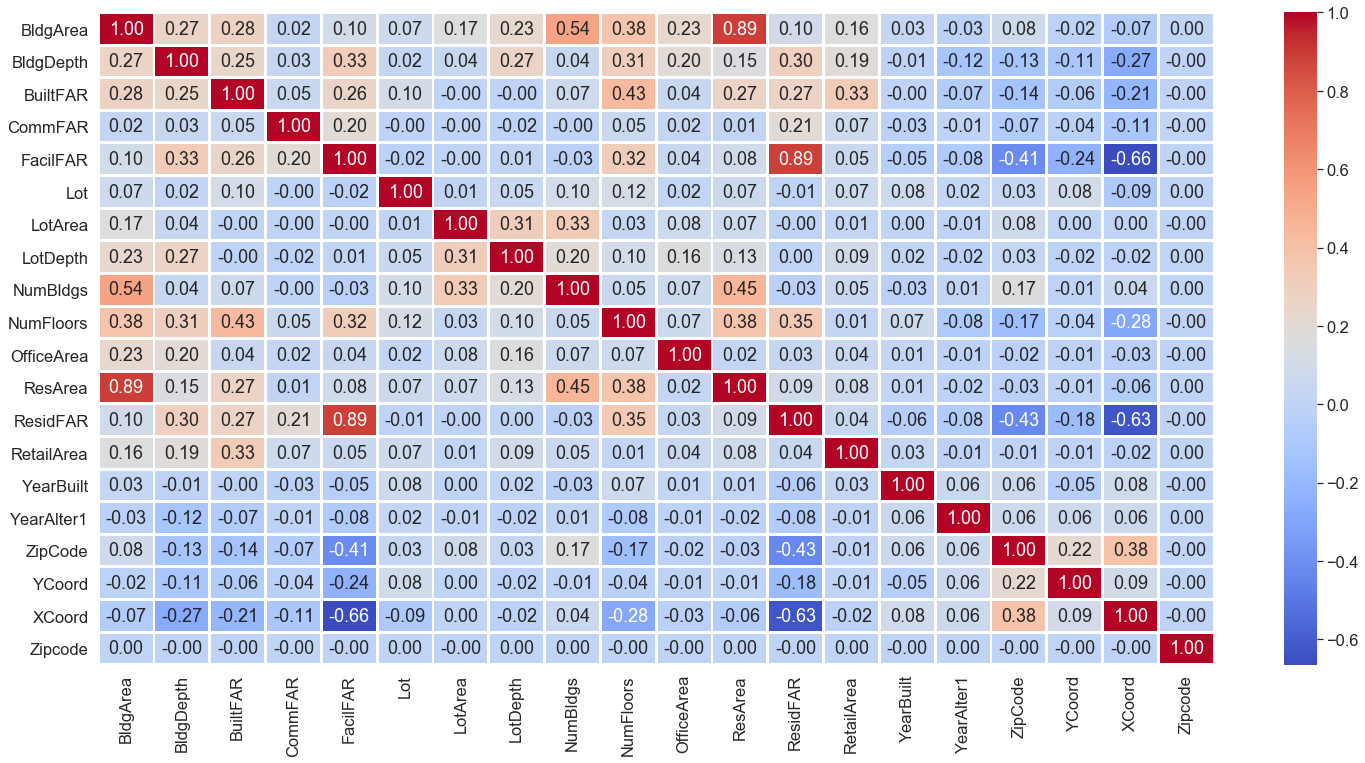

In [77]:
plt.figure(figsize=(25,12))
sns.heatmap(df5.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

## Multicollinearity observed for ResArea/BldgArea; ResidFAR/FaciliFAR 

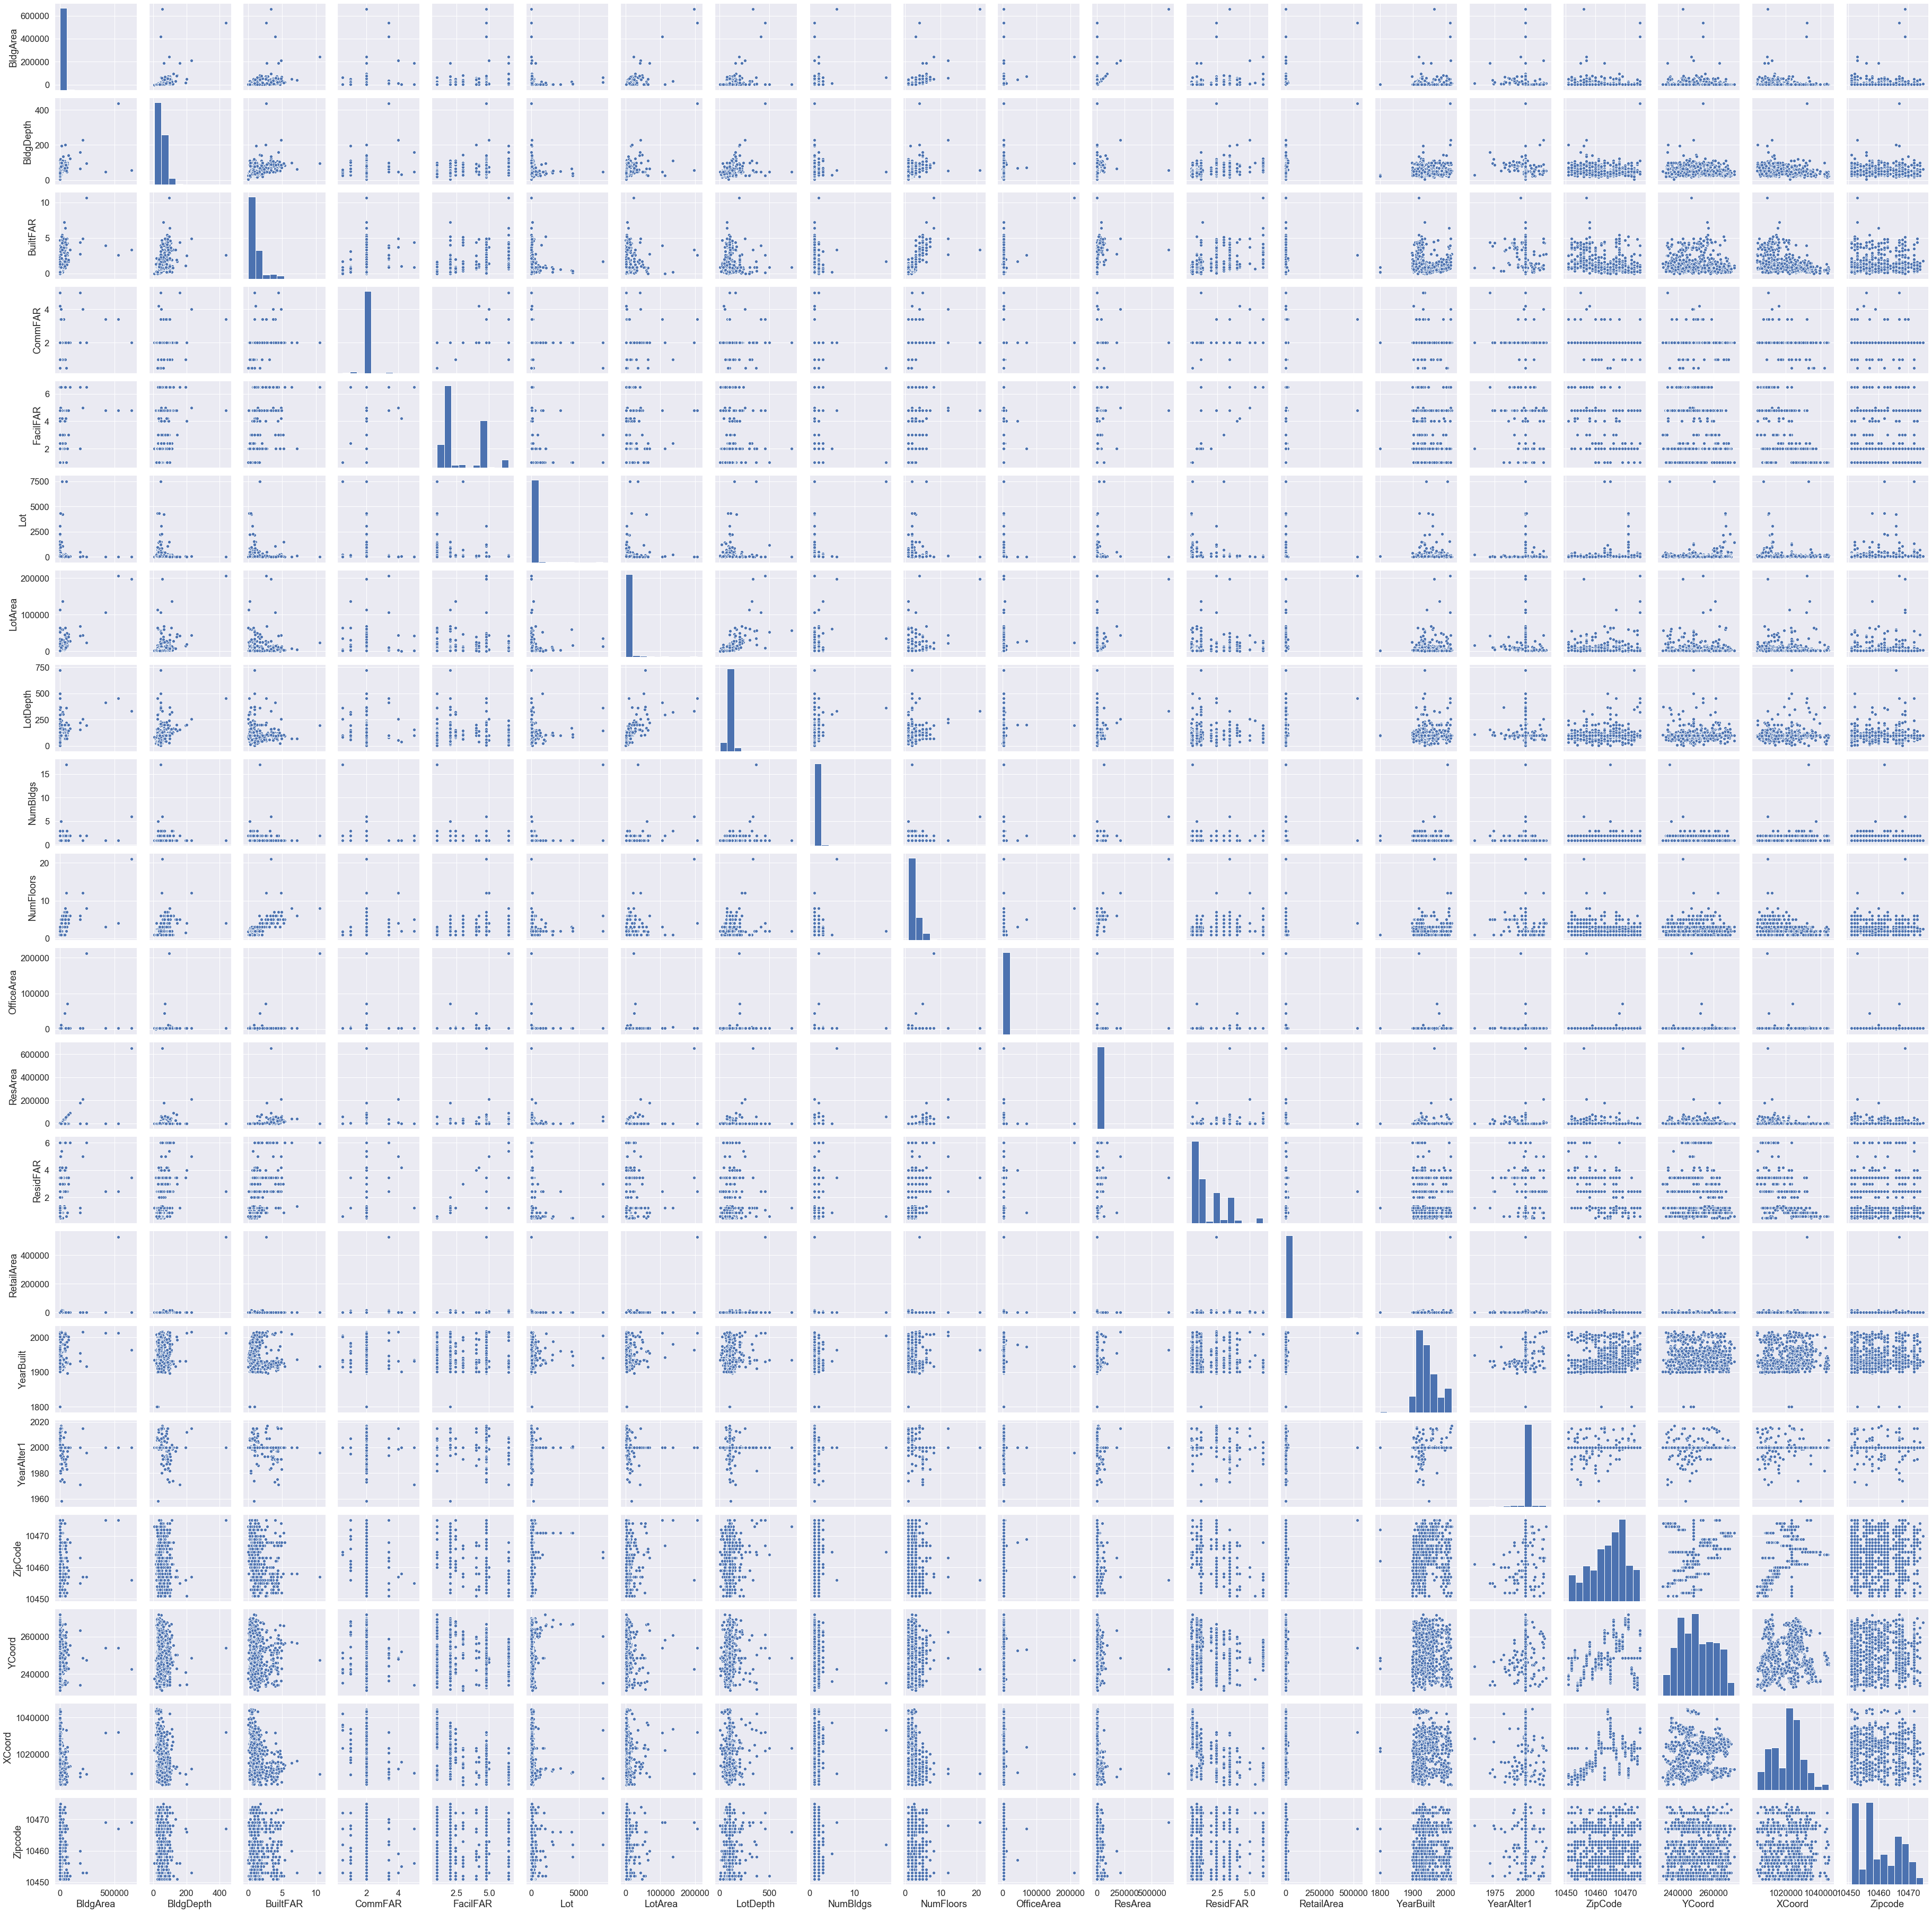

In [78]:
sns.pairplot(df5.sample(1000))
plt.show()

### Treat Duplicate Values

In [79]:
df5.duplicated(keep='first').sum()

0

### Treat Outliers

In [80]:
df5.columns

Index(['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR',
       'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea',
       'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1',
       'ZipCode', 'YCoord', 'XCoord', 'ComplaintType', 'Zipcode', 'Street',
       'Borough'],
      dtype='object')

In [81]:
df5.describe()

BldgArea     BldgDepth      BuiltFAR       CommFAR      FacilFAR  \
count  8.985400e+04  89854.000000  89854.000000  89854.000000  89854.000000   
mean   8.280879e+03     51.652695      1.172450      1.996515      2.878297   
std    6.518636e+04     28.237084      1.773936      0.304805      1.576991   
min    1.000000e+00      2.000000      0.010000      0.500000      1.000000   
25%    1.771000e+03     36.000000      0.640000      2.000000      2.000000   
50%    2.340000e+03     46.000000      0.900000      2.000000      2.000000   
75%    3.288000e+03     55.000000      1.250000      2.000000      4.800000   
max    1.354011e+07   1300.000000    259.800000      9.000000     10.000000   

                Lot       LotArea      LotDepth      NumBldgs     NumFloors  \
count  89854.000000  8.985400e+04  89854.000000  89854.000000  89854.000000   
mean     111.493601  1.024746e+04    106.266331      1.252343      2.419035   
std      467.387099  3.058250e+05     73.727413      1.904116      1.355107   
min        1.000000  1.000000e+00      0.080000      1.000000      0.500000   
25%       20.000000  2.200000e+03     95.000000      1.000000      2.000000   
50%       41.000000  2.513000e+03    100.000000      1.000000      2.000000   
75%       73.000000  4.250000e+03    102.420000      1.000000      3.000000   
max     9978.000000  7.425000e+07   8000.000000    251.000000     44.000000   

         OfficeArea       ResArea      ResidFAR     RetailArea     YearBuilt  \
count  8.985400e+04  8.985400e+04  89854.000000   89854.000000  89854.000000   
mean   3.059572e+03  6.043332e+03      1.735470    2646.738376   1942.808078   
std    1.186597e+04  5.657408e+04      1.258452    4783.403278     28.775661   
min    5.000000e+01  1.000000e+02      0.500000     100.000000   1780.000000   
25%    2.628000e+03  1.482000e+03      0.900000    2458.000000   1925.000000   
50%    2.628000e+03  2.000000e+03      1.250000    2458.000000   1935.000000   
75%    2.628000e+03  2.616000e+03      2.430000    2458.000000   1960.000000   
max    1.311800e+06  1.321140e+07     10.000000  598908.000000   2017.000000   

         YearAlter1       ZipCode         YCoord        XCoord       Zipcode  
count  89854.000000  89854.000000   89854.000000  8.985400e+04  89854.000000  
mean    1999.816124  10464.283360  249925.273165  1.021745e+06  10460.668273  
std        3.958911      7.278894    9603.154734  8.447483e+03      6.539841  
min     1905.000000  10451.000000  227527.000000  1.002677e+06  10451.000000  
25%     2000.000000  10460.000000  242114.000000  1.014688e+06  10456.000000  
50%     2000.000000  10465.000000  248586.000000  1.023321e+06  10460.000000  
75%     2000.000000  10469.000000  257679.000000  1.026939e+06  10467.000000  
max     2017.000000  11370.000000  272275.000000  1.047777e+06  10803.000000

### Drop unwanted features

In [82]:
df5.columns

Index(['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR',
       'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea',
       'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1',
       'ZipCode', 'YCoord', 'XCoord', 'ComplaintType', 'Zipcode', 'Street',
       'Borough'],
      dtype='object')

In [83]:
df5.drop(['Address','YCoord', 'XCoord', 'ComplaintType', 'Zipcode', 'Street',
       'Borough'],axis=1,inplace=True)

In [84]:
df5.head()

BldgArea  BldgDepth  BuiltFAR  CommFAR  FacilFAR  Lot  LotArea  LotDepth  \
0    2340.0       46.0      0.90      5.0       6.5    1  15000.0     200.0   
1     752.0       16.0      0.05      5.0       6.5    4  13770.0     100.0   
2   39375.0      200.0      1.13      5.0       6.5   10  35000.0     200.0   
3   12500.0       85.0      5.00      5.0       6.5   17   2500.0     100.0   
4    8595.0       70.0      4.58      5.0       6.5   18   1875.0      75.0   

   NumBldgs  NumFloors  OfficeArea  ResArea  ResidFAR  RetailArea  YearBuilt  \
0       1.0        2.0      2628.0   2000.0      6.02      2458.0     1935.0   
1       2.0        1.0       272.0   2000.0      6.02      2458.0     1931.0   
2       1.0        2.0      2628.0   2000.0      6.02      2458.0     1931.0   
3       1.0        5.0      2628.0  12500.0      6.02      2458.0     1931.0   
4       1.0        5.0      2628.0   6876.0      6.02      1719.0     1920.0   

   YearAlter1  ZipCode  
0      2000.0  10454.0  
1      1994.0  10454.0  
2      2000.0  10454.0  
3      2001.0  10454.0  
4      2009.0  10454.0

In [85]:
df5['Age'] = df5['YearAlter1'] - df5['YearBuilt']

In [86]:
df5.head()

BldgArea  BldgDepth  BuiltFAR  CommFAR  FacilFAR  Lot  LotArea  LotDepth  \
0    2340.0       46.0      0.90      5.0       6.5    1  15000.0     200.0   
1     752.0       16.0      0.05      5.0       6.5    4  13770.0     100.0   
2   39375.0      200.0      1.13      5.0       6.5   10  35000.0     200.0   
3   12500.0       85.0      5.00      5.0       6.5   17   2500.0     100.0   
4    8595.0       70.0      4.58      5.0       6.5   18   1875.0      75.0   

   NumBldgs  NumFloors  OfficeArea  ResArea  ResidFAR  RetailArea  YearBuilt  \
0       1.0        2.0      2628.0   2000.0      6.02      2458.0     1935.0   
1       2.0        1.0       272.0   2000.0      6.02      2458.0     1931.0   
2       1.0        2.0      2628.0   2000.0      6.02      2458.0     1931.0   
3       1.0        5.0      2628.0  12500.0      6.02      2458.0     1931.0   
4       1.0        5.0      2628.0   6876.0      6.02      1719.0     1920.0   

   YearAlter1  ZipCode   Age  
0      2000.0  10454.0  65.0  
1      1994.0  10454.0  63.0  
2      2000.0  10454.0  69.0  
3      2001.0  10454.0  70.0  
4      2009.0  10454.0  89.0

In [87]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89854 entries, 0 to 89853
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BldgArea    89854 non-null  float64
 1   BldgDepth   89854 non-null  float64
 2   BuiltFAR    89854 non-null  float64
 3   CommFAR     89854 non-null  float64
 4   FacilFAR    89854 non-null  float64
 5   Lot         89854 non-null  int64  
 6   LotArea     89854 non-null  float64
 7   LotDepth    89854 non-null  float64
 8   NumBldgs    89854 non-null  float64
 9   NumFloors   89854 non-null  float64
 10  OfficeArea  89854 non-null  float64
 11  ResArea     89854 non-null  float64
 12  ResidFAR    89854 non-null  float64
 13  RetailArea  89854 non-null  float64
 14  YearBuilt   89854 non-null  float64
 15  YearAlter1  89854 non-null  float64
 16  ZipCode     89854 non-null  float64
 17  Age         89854 non-null  float64
dtypes: float64(17), int64(1)
memory usage: 12.3 MB


### Create and save processed dataset

In [88]:
#df5.to_csv("partfour.csv",index=False)